In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

In [5]:
#map inputs to (-1,1) for better training
X_train, X_test = X_train/255.0 * 2 - 1, X_test/255.0 * 2 - 1
X_train.shape

(60000, 28, 28)

In [6]:
#Flatten the data
N,H,W = X_train.shape
D = H*W
X_train = X_train.reshape(-1,D)
X_test = X_test.reshape(-1,D)

In [7]:
#Dimentionality of latent space
latent_dim = 100

In [8]:
# Generator model
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(D, activation='tanh')(x)
    
    model = Model(i,x)
    return(model)

In [9]:
# Descriminator model
def build_descriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(i,x)
    return(model)

In [10]:
# Compile both models in preparation for training

# Build and compile descriminator
descriminator = build_descriminator(D)
descriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002,0.5),
    metrics=['accuracy']
)

# Build and compile the combined model
generator = build_generator(latent_dim)

# Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# pass the noise through generator to get an image as functinal api (Entire model is used as layer)
img = generator(z)

# make sure only generator is trained (Desciminator is not trained by the combined model, it will train independently based on its compilation parameters)
descriminator.trainable = False

# the true output is fake but we lable them real(use functinal api same as above) : output of descriminator for our fake image
fake_pred = descriminator(img)

# Create the combined model object
combined_model = Model(z, fake_pred)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002,0.5)
)

In [11]:
# Train the GAN

# Config
batch_size = 32
epochs = 30000
sample_period = 200  # every sample period generate and save some data

# Create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

# Create a folder to store generated images
if not os.path.exists('gan_images'):
    os.mkdir('gan_images')

In [14]:
# function to save a random grid from generator and save it to file
def sample_image(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    
    # rescale image to 0-1
    imgs = 0.5 * imgs + 0.5
    
    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H,W), cmap='gray')
            axs[i,j].axis('off')
            idx= idx + 1
            
    fig.savefig("gan_images/%d.png" %epoch)
    plt.close()

In [15]:
# Main training loop
for epoch in range(epochs):
    #######################
    # Train Descriminator #
    #######################
    
    # Real Images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx]
    
    # Fake images
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    # Train the descriminator
    # Both loss and accuracy are returned
    d_loss_real, d_acc_real = descriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = descriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    
    #######################
    #   Train Generator   #
    #######################
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    # Save the losses
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch:{epoch+1}/{epochs}, d_loss:{d_loss:.2f}, d_acc:{d_acc:.2f}, g_loss:{g_loss:.2f}")
        
    if epoch % sample_period == 0:
        sample_image(epoch)
        
sample_image(30000)

epoch:1/30000, d_loss:0.30, d_acc:0.97, g_loss:0.72
epoch:101/30000, d_loss:0.01, d_acc:1.00, g_loss:4.86
epoch:201/30000, d_loss:0.03, d_acc:1.00, g_loss:4.47
epoch:301/30000, d_loss:0.12, d_acc:0.98, g_loss:3.97
epoch:401/30000, d_loss:0.16, d_acc:0.97, g_loss:3.44
epoch:501/30000, d_loss:0.66, d_acc:0.52, g_loss:0.78
epoch:601/30000, d_loss:0.65, d_acc:0.55, g_loss:0.78
epoch:701/30000, d_loss:0.60, d_acc:0.75, g_loss:0.75
epoch:801/30000, d_loss:0.62, d_acc:0.70, g_loss:0.78
epoch:901/30000, d_loss:0.64, d_acc:0.64, g_loss:0.78
epoch:1001/30000, d_loss:0.62, d_acc:0.70, g_loss:0.83
epoch:1101/30000, d_loss:0.60, d_acc:0.73, g_loss:0.88
epoch:1201/30000, d_loss:0.60, d_acc:0.80, g_loss:0.95
epoch:1301/30000, d_loss:0.57, d_acc:0.72, g_loss:0.89
epoch:1401/30000, d_loss:0.58, d_acc:0.72, g_loss:0.91
epoch:1501/30000, d_loss:0.61, d_acc:0.64, g_loss:0.96
epoch:1601/30000, d_loss:0.59, d_acc:0.75, g_loss:0.83
epoch:1701/30000, d_loss:0.56, d_acc:0.75, g_loss:0.97
epoch:1801/30000, d_lo

epoch:14901/30000, d_loss:0.69, d_acc:0.58, g_loss:0.94
epoch:15001/30000, d_loss:0.63, d_acc:0.64, g_loss:0.85
epoch:15101/30000, d_loss:0.62, d_acc:0.64, g_loss:1.07
epoch:15201/30000, d_loss:0.63, d_acc:0.69, g_loss:1.10
epoch:15301/30000, d_loss:0.60, d_acc:0.67, g_loss:0.96
epoch:15401/30000, d_loss:0.69, d_acc:0.52, g_loss:1.00
epoch:15501/30000, d_loss:0.60, d_acc:0.62, g_loss:1.02
epoch:15601/30000, d_loss:0.80, d_acc:0.42, g_loss:1.03
epoch:15701/30000, d_loss:0.62, d_acc:0.62, g_loss:1.01
epoch:15801/30000, d_loss:0.62, d_acc:0.67, g_loss:1.00
epoch:15901/30000, d_loss:0.64, d_acc:0.64, g_loss:0.91
epoch:16001/30000, d_loss:0.70, d_acc:0.62, g_loss:0.92
epoch:16101/30000, d_loss:0.62, d_acc:0.66, g_loss:1.00
epoch:16201/30000, d_loss:0.74, d_acc:0.52, g_loss:1.05
epoch:16301/30000, d_loss:0.60, d_acc:0.59, g_loss:1.08
epoch:16401/30000, d_loss:0.65, d_acc:0.61, g_loss:1.04
epoch:16501/30000, d_loss:0.74, d_acc:0.55, g_loss:1.00
epoch:16601/30000, d_loss:0.68, d_acc:0.56, g_lo

epoch:29601/30000, d_loss:0.56, d_acc:0.69, g_loss:1.10
epoch:29701/30000, d_loss:0.69, d_acc:0.61, g_loss:0.94
epoch:29801/30000, d_loss:0.67, d_acc:0.61, g_loss:1.06
epoch:29901/30000, d_loss:0.54, d_acc:0.69, g_loss:1.05


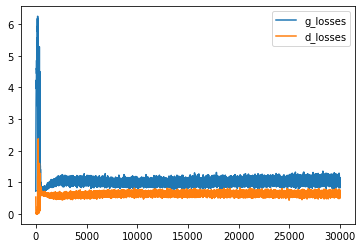

In [16]:
# Plot the losses
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()
plt.show()

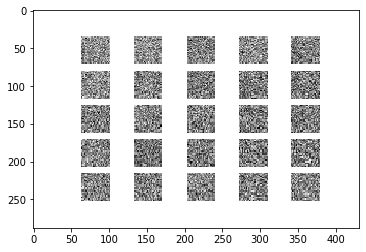

In [17]:
# Plot generated images
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

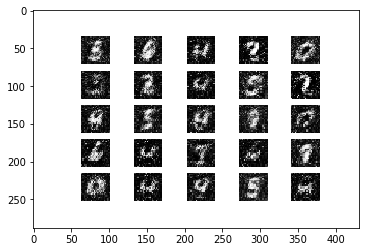

In [18]:
a = imread('gan_images/1000.png')
plt.imshow(a)

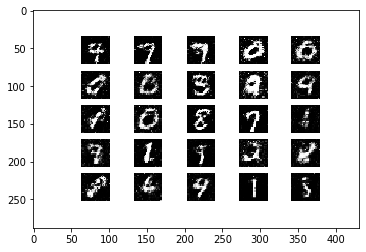

In [19]:
a = imread('gan_images/5000.png')
plt.imshow(a)

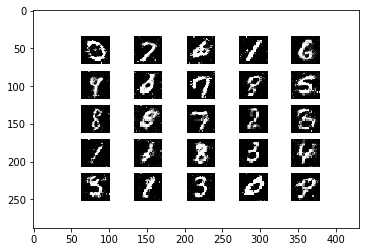

In [20]:
a = imread('gan_images/10000.png')
plt.imshow(a)

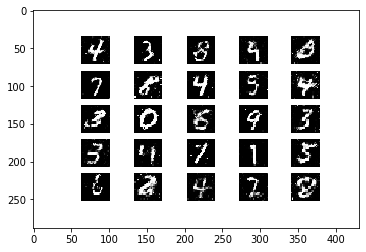

In [21]:
a = imread('gan_images/20000.png')
plt.imshow(a)

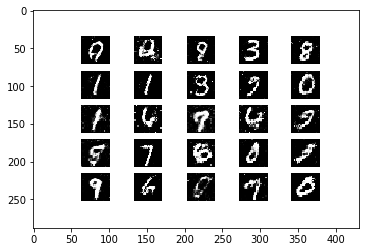

In [22]:
a = imread('gan_images/29800.png')
plt.imshow(a)

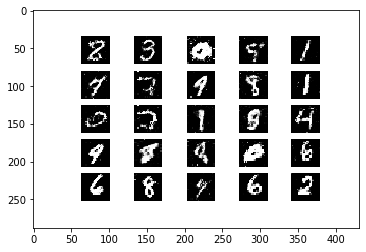

In [23]:
a = imread('gan_images/30000.png')
plt.imshow(a)